In [1]:
## Reload the modules each time there are modified
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.arms import Bernoulli
from src.stochastic_bandit import MAB, BernoulliMAB
from src.multiplayers import multiplayer_env, PlayerRandTop, UCB1Policy, KlUCBPolicy

In [3]:
arm = Bernoulli(0.4)
arm

Bernoulli(0.4)

(0.0, 1.5)

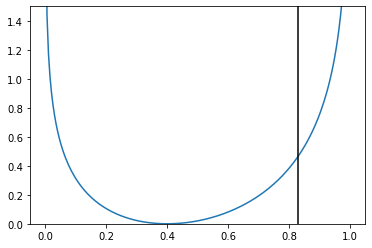

In [24]:
qq = np.linspace(0, 1, 200)
plt.plot(qq, [Bernoulli.kl(0.4, q) for q in qq])

plt.axvline(Bernoulli.kl_ucb(0.4, np.log(100) / 10), c="k")

plt.ylim([0, 1.5])

In [25]:
Bernoulli.kl_ucb(0.4, np.log(100) / 10)

0.8286230589491665

In [26]:
Bernoulli.kl_ucb(0.9, np.log(10), 1e-6)

0.9999996185302734

In [27]:
arm.kl_ucb(0.4, np.log(100)/10, 0.1)

0.8286230589491665

In [15]:
MAB([Bernoulli(0.2), Bernoulli(0.3)], m=2), BernoulliMAB([0.2, 0.3])

(MAB([Bernoulli(0.2), Bernoulli(0.3)]), BernoulliMAB([0.2, 0.3]))

In [17]:
bandit = BernoulliMAB([0.2, 0.3, 0.5, 0.75, 0.8])
K, M = bandit.nb_arms, 3
policy = UCB1Policy(alpha=0.5)
players = [PlayerRandTop(K, M, policy) for _ in range(M)]

In [18]:
selections, collisions, sensing_infos = multiplayer_env(bandit, players, 44)

In [19]:
j = 1
L = [0] * K
for i in range(len(selections[0])):
    L[selections[j,i]] += sensing_infos[j,i]
L

[3.0, 0.0, 4.0, 4.0, 19.0]

In [20]:
players[j].cum_rewards

array([ 3.,  0.,  4.,  4., 19.])

In [27]:
banditA = BernoulliMAB([0.45, 0.5, 0.6])
banditB = BernoulliMAB([0.1, 0.05, 0.02, 0.01])

K, M = banditA.nb_arms, 1
kl_ucb_policy = KlUCBPolicy(arms_types=banditA.arms)
players = [PlayerRandTop(K, M, kl_ucb_policy) for _ in range(M)]

selections, collisions, sensing_infos = multiplayer_env(banditA, players, 2000)

In [29]:
rewards = sensing_infos * (~ collisions)

In [23]:
 L = [1, 2, 4, 5, 6, 7, 8, 9]
 c = np.array([False, False, False, True, False, True, True, False])
 np.where(~c, L, 0), ~c * L

(array([1, 2, 4, 0, 6, 0, 0, 9]), array([1, 2, 4, 0, 6, 0, 0, 9]))